In [620]:
#CONDA ENV pytorch1 (python 3.9.7)
#Import packages
#---------------------------------------
import sys
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
import process_functions as pf
import pyBigWig as bw
import torch
from enformer_pytorch import Enformer, GenomeIntervalDataset
import polars as pl
from torch import Tensor

#Import your modules
#---------------------------------------
sys.path.insert(1, '/cndd3/dburrows/CODE/admin_tools/')
from admin_tools import admin_functions as adm

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
print(f'Python version {sys.version}')
print(f'Python path {sys.executable}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
Python path /home/dburrows/mambaforge/envs/pytorch1/bin/python


In [513]:
#Load in data, nonan
splice = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/SJ.comb.nonan.bed', sep='\t', index_col=0)
#splice.index = splice['id-unique'] #set spliceid as index
mcg = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/CG.bingraph.nonan.raw', sep='\t', index_col=0)
mch = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/CAC.bingraph.nonan.raw', sep='\t', index_col=0)
atac = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/ATAC.bingraph.nonan.raw', sep='\t', index_col=0)

/tmp/ipykernel_2642216/2337270338.py:2: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  splice = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/SJ.comb.nonan.bed', sep='\t', index_col=0)


# Deal with nans

In [504]:
#load in data with nan
splice = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/SJ.comb.bed', sep='\t', index_col=0)
splice.index = splice['id-unique'] #set spliceid as index
mcg = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/CG.bingraph.raw', sep='\t', index_col=0)
mch = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/CAC.bingraph.raw', sep='\t', index_col=0)
atac = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/ATAC.bingraph.raw', sep='\t', index_col=0)

/tmp/ipykernel_2642216/1356148680.py:2: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  splice = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/SJ.comb.bed', sep='\t', index_col=0)


In [512]:
#remove nans by imputing and averaging neighbours
#=================================================
max_nan = 10 #up to 10 nans per SJ allowed
mcg_nn, mcg_id = remove_nans_impute(mcg, max_nan)
mch_nn, mch_id = remove_nans_impute(mch, max_nan)

#find unique ids 
unq_id = np.unique(np.append(mcg_id, mch_id))

#filter splice and atac, cg + mch
# Dropping rows in place and ignoring errors for missing indices
splice.drop(unq_id, inplace=True, errors='ignore')
atac.drop(unq_id, inplace=True, errors='ignore')

#filter mcg + mch; NB do on nan filtered files
mcg_nn.drop(unq_id, inplace=True, errors='ignore')
mch_nn.drop(unq_id, inplace=True, errors='ignore')
assert len(splice) == len(atac) == len(mcg_nn) == len(mch_nn), 'Some nan-filtered files not the same length'

#make sure all follow the same order
atac = atac.loc[splice.index.values]
mcg_nn = mcg_nn.loc[splice.index.values]
mch_nn = mch_nn.loc[splice.index.values]
assert sum(splice.index.values == atac.index.values) == len(splice.index), 'some atac ids dont match SJs'
assert sum(splice.index.values == mcg_nn.index.values) == len(splice.index), 'some mcg ids dont match SJs'
assert sum(splice.index.values == mch_nn.index.values) == len(splice.index), 'some mch ids dont match SJs'

splice.to_csv('/cndd2/dburrows/DATA/splice/model/processed_data/SJ.comb.nonan.bed', sep='\t', header=True, index=True)
atac.to_csv('/cndd2/dburrows/DATA/splice/model/processed_data/ATAC.bingraph.nonan.raw', sep='\t', index=True)
mcg_nn.to_csv('/cndd2/dburrows/DATA/splice/model/processed_data/CG.bingraph.nonan.raw', sep='\t', index=True)
mch_nn.to_csv('/cndd2/dburrows/DATA/splice/model/processed_data/CAC.bingraph.nonan.raw', sep='\t', index=True)

/tmp/ipykernel_2642216/382728774.py:39: RuntimeWarning: Mean of empty slice
  new_v = np.nanmean(np.vstack((sub_curr.values[left], sub_curr.values[right])), axis=0)  # Take mean either side, ignore NaNs


In [274]:
#Deal with nans
print(f'{np.ceil((sum(np.sum(np.isnan(mcg).values,axis=1) > 0) / len(mcg))*100)}% of SJs contain mcg nans') 
print(f'{np.ceil((sum(np.sum(np.isnan(mch).values,axis=1) > 0) / len(mch))*100)}% of SJs contain mch nans') 

14.0% of SJs contain mcg nans
2.0% of SJs contain mch nans


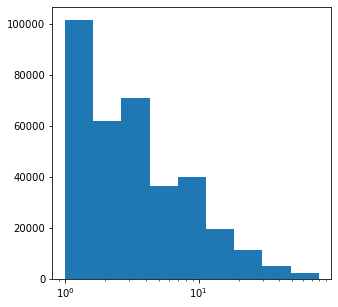

In [241]:
#plot number of nans in mcg
curr = mcg.values
sum_nan = np.sum(np.isnan(curr),axis=1)
fig,ax = plt.subplots(figsize=(5,5))
plt.hist(sum_nan,bins=np.geomspace(1,np.max(sum_nan),10))
plt.xscale('log')
plt.show()

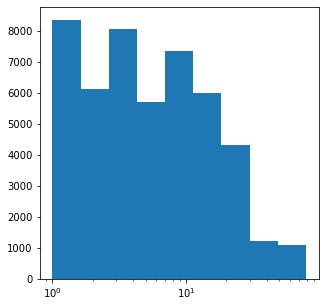

In [239]:
#plot number of nans in mch
curr = mch.values
sum_nan = np.sum(np.isnan(curr),axis=1)
fig,ax = plt.subplots(figsize=(5,5))
plt.hist(sum_nan,bins=np.geomspace(1,np.max(sum_nan),10))
plt.xscale('log')
plt.show()

In [404]:
curr= mcg
max_nan = 10 #max number of nans per SJ for inclusion
remove_id = [] #ids to remove

sum_nan = np.sum(np.isnan(curr.values),axis=1) #find number of nans per SJ
remove_id.append(curr[sum_nan > max_nan].index.values) #ids to remove
sub_curr = curr[sum_nan < max_nan].copy() #extract only SJs with fewer nan than max_nan

#keep looping until no nans remain
loc = np.where(np.isnan(sub_curr.values)==True)
count=1
while np.sum(np.isnan(sub_curr.values)) > 0:
    loc = np.where(np.isnan(sub_curr.values)==True)
    left = loc[0],loc[1]-count
    left[1][left[1] < 0] = 0
    right = loc[0],loc[1]+count
    right[1][right[1] >= curr.shape[1]] = curr.shape[1] - 1
    
    new_v = np.nanmean(np.vstack((sub_curr.values[left], sub_curr.values[right])),axis=0) #take mean either side and ignore nans
    sub_curr.values[loc] = new_v
    count+=1

assert np.sum(np.isnan(sub_curr.values)) == 0, 'nans still left'


/tmp/ipykernel_2642216/947742712.py:19: RuntimeWarning: Mean of empty slice
  new_v = np.nanmean(np.vstack((sub_curr.values[left], sub_curr.values[right])),axis=0) #take mean either side and ignore nans


In [388]:
#Visualise nan imputing
sum_nan = np.sum(np.isnan(curr.values),axis=1) #find number of nans per SJ
remove_id.append(curr[sum_nan > max_nan].index.values) #ids to remove
wub_curr = curr[sum_nan < max_nan].copy()


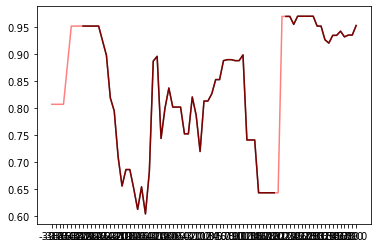

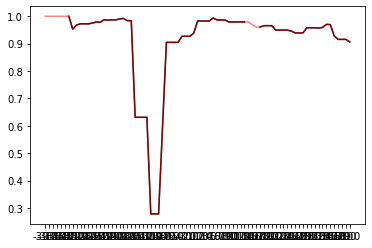

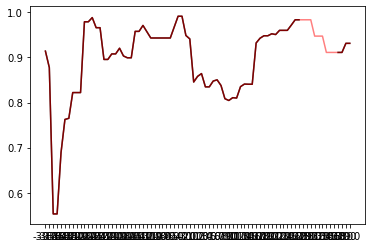

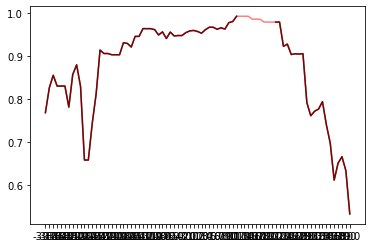

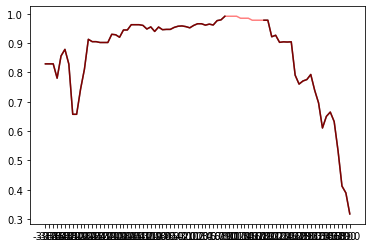

In [406]:
ok = curr[sum_nan == 9][::2]
for i in range(5):
    curr_ind = ok.index[i]
    plt.plot(ok.iloc[i], c='k')
    plt.plot(sub_curr.loc[curr_ind], c='red',alpha=0.5)
    plt.show()

# Run MLP on binned epi data only

In [621]:
#set seed for RNG
torch.manual_seed(42)

In [622]:
#subset data for practice run
#=====================================================
train_splice = splice[splice['chromosome'] == 'chr1']
train_mcg = mcg.loc[train_splice.index.values]
train_mch = mch.loc[train_splice.index.values]
train_atac = atac.loc[train_splice.index.values]
assert len(train_splice) == len(train_mcg) == len(train_mch) == len(train_atac)

val_splice = splice[splice['chromosome'] == 'chr16']
val_mcg = mcg.loc[val_splice.index.values]
val_mch = mch.loc[val_splice.index.values]
val_atac = atac.loc[val_splice.index.values]
assert len(val_splice) == len(val_mcg) == len(val_mch) == len(val_atac)

test_splice = splice[splice['chromosome'] == 'chr18']
test_mcg = mcg.loc[test_splice.index.values]
test_mch = mch.loc[test_splice.index.values]
test_atac = atac.loc[test_splice.index.values]
assert len(test_splice) == len(test_mcg) == len(test_mch) == len(test_atac)

print(f'Train samples = {len(train_splice)}')
print(f'Val samples = {len(val_splice)}')
print(f'Test samples = {len(test_splice)}')
print(
    f"""Split: {np.round(len(train_splice)/(len(train_splice)+len(val_splice)+len(test_splice)),2)*100} %train,
      {np.round(len(val_splice)/(len(train_splice)+len(val_splice)+len(test_splice)),2)*100} %val,
      {np.round(len(test_splice)/(len(train_splice)+len(val_splice)+len(test_splice)),2)*100} %test
      """)

Train samples = 156380
Val samples = 82664
Test samples = 61440
Split: 52.0 %train,
      28.000000000000004 %val,
      20.0 %test
      


In [623]:
#Instantiate dataset objects for train, test and val
train_dataset = episplice_dataset(id_ord = train_splice.index.values, splice=train_splice['CPM'], 
                                  mcg=train_mcg, mch=train_mch, 
                                  atac=train_atac, pos_enc = (train_mcg.columns.values).astype(float), 
                                  mode='binned')

val_dataset = episplice_dataset(id_ord = val_splice.index.values, 
                                splice=val_splice['CPM'], mcg=val_mcg, mch=val_mch, 
                                atac=val_atac, pos_enc = (val_mcg.columns.values).astype(float), 
                                mode='binned')


test_dataset = episplice_dataset(id_ord = test_splice.index.values,
                                 splice=test_splice['CPM'], mcg=test_mcg, mch=test_mch, 
                                 atac=test_atac, pos_enc = (test_mcg.columns.values).astype(float), 
                                 mode='binned')


In [624]:
#DataLoader
from torch.utils.data import DataLoader

batch_size = 64


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5, 
                          persistent_workers=True, drop_last=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=5, 
                        persistent_workers=True, drop_last=False)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=5, 
                         persistent_workers=True, drop_last=False)

In [ ]:
# Initialise model
model = episplice_MLP(input_dim=30, hidden_dim=64)  # Adjust input_dim and hidden_dim as necessary


In [592]:
train_dataset = episplice_dataset(id_ord = train_splice.index.values, splice=train_splice['CPM'], 
                                  mcg=train_mcg, mch=train_mch, 
                                  atac=train_atac, pos_enc = (train_mcg.columns.values).astype(float), 
                                  mode='continuous')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5, 
                          persistent_workers=True, drop_last=True)

In [576]:
# Fetch a single data point 
index_to_check = 54
data_point = train_dataset.__getitem__(index_to_check)

# Assuming your __getitem__ returns a tuple of tensors, you might need to process it accordingly
splice_idx, seq_idx, mcg_idx, mch_idx, atac_idx, pos_enc_idx, unq = data_point

print("Splice Index Tensor:", splice_idx)
print("MCG Index Tensor:", mcg_idx)
print("MCH Index Tensor:", mch_idx)
print("ATAC Index Tensor:", atac_idx)
print("Positional Encoding:", pos_enc_idx)
print(unq)

Splice Index Tensor: tensor(0.3899)
MCG Index Tensor: tensor([0.0039, 0.0031, 0.0088, 0.0087, 0.0094, 0.1500, 0.1797, 0.2247, 0.4562,
        0.6842, 0.8950, 0.9153, 0.9269, 0.9325, 0.8996, 0.8996, 0.8943, 0.8868,
        0.8965, 0.8806, 0.8401, 0.8528, 0.9036, 0.9036, 0.8993, 0.9043, 0.8941,
        0.8917, 0.9242, 0.9206, 0.8629, 0.8629, 0.8578, 0.8716, 0.8476, 0.8390,
        0.8515, 0.8763, 0.9158, 0.9228, 0.9228, 0.9248, 0.9246, 0.9130, 0.9076,
        0.8781, 0.8626, 0.8597, 0.8717, 0.8891, 0.9218, 0.9004, 0.8919, 0.9107,
        0.9025, 0.9093, 0.9108, 0.8944, 0.8730, 0.9308, 0.8645, 0.8706, 0.8890,
        0.8867, 0.8758, 0.8758, 0.8933, 0.8952, 0.9536, 0.9527, 0.8532, 0.8277,
        0.8462, 0.8462, 0.8426, 0.8251, 0.8001, 0.7761, 0.9099])
MCH Index Tensor: tensor([0.0085, 0.0080, 0.0083, 0.0142, 0.0167, 0.0167, 0.0187, 0.0197, 0.0256,
        0.0310, 0.0337, 0.0366, 0.0379, 0.0379, 0.0364, 0.0446, 0.0452, 0.0434,
        0.0361, 0.0305, 0.0268, 0.0348, 0.0368, 0.0295, 0.0278,

In [ ]:
# Fetch a single data point 
index_to_check = 10
data_point = train_dataset.__getitem__(index_to_check)

# Assuming your __getitem__ returns a tuple of tensors, you might need to process it accordingly
splice_idx, vec ,unq = data_point

# Add any additional print/debug statements as necessary


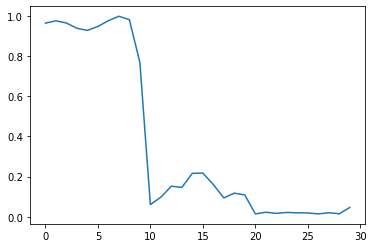

In [568]:
plt.plot(vec)

In [580]:
train_loader

In [606]:
# Fetch a few batches and inspect them
for i, batch in enumerate(train_loader):
    splice_idx,seq_idx, mcg_idx, mch_idx, atac_idx, pos_enc_idx, unique_id= batch
#     print(f"Batch {i} - Features Shape: {features.shape}, Labels Shape: {labels.shape}")
    
    if i == 5:  # Inspect just the first 2 batches
        break


In [607]:
splice_idx

tensor([2.5680e-01, 1.3869e-01, 3.0607e-02, 6.0794e-02, 3.1553e-01, 3.3747e-02,
        9.1117e-03, 4.3034e-01, 1.5751e-01, 2.2951e-01, 3.7013e-03, 7.9305e-03,
        1.5165e-01, 3.0542e-01, 1.5901e-01, 1.2196e-02, 3.8116e-01, 1.1386e-02,
        4.3717e-02, 4.8173e-03, 9.7786e+00, 8.6396e-01, 1.9726e-03, 1.2481e-01,
        6.8410e-01, 2.2335e-02, 3.5080e-01, 2.5282e-01, 1.8255e-01, 4.9181e-02,
        2.2363e-01, 1.1649e-01, 8.8117e-02, 1.3259e+00, 8.8436e-02, 2.3647e-03,
        4.5073e-01, 1.0635e+00, 1.8641e-01, 1.2350e-01, 6.5691e-03, 1.1504e-02,
        7.9396e-02, 1.3808e-01, 7.4751e-03, 7.8685e-03, 1.2196e-02, 1.6767e-02,
        1.1817e-01, 1.3437e-02, 2.7392e-01, 4.0240e-01, 2.3307e+00, 3.5554e-01,
        5.6239e-02, 4.5538e-02, 6.7746e-02, 1.7077e-01, 2.7024e+00, 3.0372e-03,
        3.9698e-03, 8.2117e-02, 6.2697e-01, 7.9396e-03])

In [608]:
train_splice.loc[np.asarray(unique_id)]['CPM']

id-unique
Pvalbchr1167361592167361803+donor       0.256802
Sstchr1120166173120188040+acceptor      0.138688
Pvalbchr1158580362158597156+donor       0.030607
L6bchr1133726564133727722-donor         0.060794
L5_ITchr14399136043992263+donor         0.315535
                                          ...   
L6_CTchr14378017043827614-acceptor      0.003037
Lamp5chr1193184605193184793-donor       0.003970
Pvalbchr16489289864921549-acceptor      0.082117
Sstchr17526214175262322-acceptor        0.626973
Lamp5chr1153250524153250611-acceptor    0.007940
Name: CPM, Length: 64, dtype: float64

In [613]:
atac_idx

tensor([[1.8838e-02, 1.8838e-02, 2.0632e-02,  ..., 1.6416e-01, 1.4173e-01,
         1.0495e-01],
        [4.6716e-15, 4.6716e-15, 5.1542e-03,  ..., 9.3491e-03, 1.2465e-02,
         1.5582e-02],
        [5.2028e-02, 6.9072e-02, 9.8675e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0764e-02, 9.8675e-03, 8.9704e-03,  ..., 3.2293e-02, 3.2293e-02,
         3.1396e-02],
        [1.8698e-02, 2.1814e-02, 2.4931e-02,  ..., 8.1747e-02, 9.3133e-02,
         9.3133e-02],
        [2.7326e-02, 2.8097e-02, 3.2779e-02,  ..., 3.5981e-02, 4.3806e-02,
         4.7718e-02]])

In [616]:
train_mch.loc[np.asarray(unique_id)]

,-39.0,-38.0,-37.0,-36.0,-35.0,-34.0,-33.0,-32.0,-31.0,-30.0,...,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
Pvalbchr1167361592167361803+donor,0.082281,0.078881,0.084612,0.078438,0.116450,0.083858,0.099779,0.100879,0.112308,0.108521,...,0.143262,0.141996,0.142212,0.140329,0.136567,0.133946,0.132558,0.129396,0.129017,0.129400
Sstchr1120166173120188040+acceptor,0.211172,0.158185,0.224213,0.248707,0.275351,0.314171,0.339845,0.405580,0.443820,0.527294,...,0.085143,0.092257,0.115050,0.131250,0.131893,0.132964,0.128729,0.168987,0.188619,0.180144
Pvalbchr1158580362158597156+donor,0.054986,0.047171,0.042286,0.037000,0.034638,0.034638,0.010600,0.010457,0.005843,0.001757,...,0.119050,0.118320,0.098600,0.095500,0.095500,0.115343,0.126633,0.066133,0.061786,0.052850
L6bchr1133726564133727722-donor,0.071647,0.080053,0.072195,0.066517,0.057717,0.035848,0.042491,0.025940,0.021254,0.009520,...,0.061673,0.072783,0.091835,0.057303,0.048117,0.068125,0.105988,0.105988,0.081748,0.076888
L5_ITchr14399136043992263+donor,0.022289,0.027319,0.023336,0.024493,0.025231,0.029995,0.029691,0.030491,0.041921,0.035490,...,0.013815,0.014202,0.015267,0.015214,0.012610,0.009338,0.008714,0.009319,0.009319,0.007622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L6_CTchr14378017043827614-acceptor,0.073829,0.072333,0.072050,0.069500,0.059367,0.052363,0.055138,0.043454,0.034371,0.040929,...,0.050825,0.056413,0.051563,0.049196,0.065100,0.083425,0.089758,0.091100,0.101017,0.097288
Lamp5chr1193184605193184793-donor,0.014619,0.007225,0.009588,0.016617,0.038442,0.056683,0.056033,0.063142,0.080504,0.135144,...,0.073513,0.079963,0.089650,0.092988,0.087381,0.086791,0.078428,0.090357,0.084916,0.070302
Pvalbchr16489289864921549-acceptor,0.241012,0.340200,0.325256,0.322606,0.308050,0.306225,0.308981,0.299681,0.245713,0.189425,...,0.139904,0.160738,0.136604,0.134867,0.133246,0.135383,0.133688,0.032119,0.049487,0.051912
Sstchr17526214175262322-acceptor,0.107607,0.111064,0.147929,0.149386,0.130043,0.147644,0.168736,0.175502,0.186132,0.157989,...,0.044875,0.043875,0.051738,0.064656,0.064344,0.067564,0.077300,0.081936,0.090383,0.097930


In [591]:
class episplice_dataset(Dataset):
    """Dataset class for Pytorch Lightning neural network models. Epi datasets will be loaded as continuous traces. 

    Datatypes:
        id_ord (array): array of unique ids in order to be used for indexing
        splice (dataframe): all SJ usage values, indexed by unique SJ id.
        seq ???
        mcg (dataframe): all binned mcg values containing flanking context of SJ, indexed by unique SJ id. Bin labels in columns must match mcg and atac, and be the same across all SJs. 
        mch (dataframe): all binned mch values containing flanking context of SJ, indexed by unique SJ id. 
        atac (dataframe): all binned atac values containing flanking context of SJ, indexed by unique SJ id. 
        pos_enc (array): labels of positional encodings for flanking epi bins.  
        mode (str): 'continuous' for loading continous epi traces, 'binned' for loading mean binned values for epi traces (used for MLP baseline) 

    """

    def __init__(self,id_ord, splice=None, seq = None, mcg=None, mch=None, atac=None, pos_enc=None, mode='continuous'):
        """ Initialise epigenetic splice dataset """
        self.id_ord = id_ord
        self.splice = splice
        self.seq = seq
        self.mcg = mcg
        self.mch = mch
        self.atac = atac
        self.pos_enc = pos_enc
        self.mode = mode
        if seq is None and mcg is None and mch is None and atac is None: 
            raise Exception('At least one datatype must be entered to make predictions')
            
        if mode != 'continuous' and mode != 'binned':
            raise Exception('Mode must be either continuous or binned')
            
        
    def __len__(self):
        """ Return length of dataset """
        return len(self.splice)
    
    def __getitem__(self,idx):
        """ Return splice, seq, mcg, mch, atac at index """
        splice_idx, seq_idx, mcg_idx, mch_idx, atac_idx,pos_enc_idx = torch.zeros((0,)), torch.zeros((0,)),torch.zeros((0,)) ,torch.zeros((0,)) ,torch.zeros((0,)) ,torch.zeros((0,)) 
        
        #use splice data to get the current id
        unique_id = self.id_ord[idx]
        
        #access SJ usage and convert to tensor
        if self.splice is not None: splice_idx = torch.tensor(self.splice.loc[unique_id], dtype=torch.float32)
        
        #output each feature separately
        if self.mode == 'continuous':
            #slice and convert to tensor
            if self.seq is not None: seq_idx = None #TBD
            if self.mcg is not None: mcg_idx = torch.tensor(self.mcg.loc[unique_id].values, dtype=torch.float32)
            if self.mch is not None: mch_idx = torch.tensor(self.mch.loc[unique_id].values, dtype=torch.float32)
            if self.atac is not None: atac_idx = torch.tensor(self.atac.loc[unique_id].values, dtype=torch.float32)
            if self.pos_enc is not None: pos_enc_idx = torch.tensor(self.pos_enc, dtype=torch.float32)

            return(splice_idx,seq_idx, mcg_idx, mch_idx, atac_idx, pos_enc_idx, unique_id)
        
        #output single vector for MLP
        if self.mode == 'binned':
            if mcg is None or mch is None or atac is None: 
                raise Exception('All epi data (mcg, mch, atac) required for binned Dataset class')
            
            nbins=10
            nbins-=1
            it = np.append([(len(self.mcg.loc[unique_id].values)//nbins)*i for i in range(nbins+1)], len(self.mcg.loc[unique_id].values)) #split indeces by 10
            mcg_idx = [np.mean(self.mcg.loc[unique_id].values[it[i]:it[i+1]]) for i in range(len(it)-1)]
            mch_idx = [np.mean(self.mch.loc[unique_id].values[it[i]:it[i+1]]) for i in range(len(it)-1)]
            atac_idx = [np.mean(self.atac.loc[unique_id].values[it[i]:it[i+1]]) for i in range(len(it)-1)]
            return(splice_idx, torch.tensor(mcg_idx + mch_idx + atac_idx, dtype=torch.float32), unique_id)
                
        

In [619]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn

class episplice_MLP(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim):
        super(episplice_MLP, self).__init__()
        # Define the architecture
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)  # Additional hidden layer for complexity
        self.output_layer = nn.Linear(hidden_dim, 1)  # Output layer to produce a single value

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x)  # No activation here, assuming a regression task
        return x

    def training_step(self, batch, batch_idx):
        # Unpack the batch
        features, labels = batch
        # Forward pass
        predictions = self(features)
        # Compute loss (assuming labels are a single value per example)
        loss = F.mse_loss(predictions.squeeze(), labels)  # Squeeze to ensure matching dimensions
        # Log the training loss
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        features, labels = batch
        predictions = self(features)
        loss = F.mse_loss(predictions.squeeze(), labels)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        # Configure the optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [ ]:
from pytorch_lightning import Trainer

# Initialize a Trainer
trainer = Trainer(max_epochs=10, gpus=1)  # Adjust according to your needs; remove gpus=1 if not using a GPU


In [ ]:
from pytorch_lightning import Trainer

model = EpiSpliceModel(input_dim=..., hidden_dim=..., output_dim=...)
trainer = Trainer(max_epochs=10)

trainer.fit(model, train_loader, val_loader)


In [ ]:
#specific architecture -> learn about MLP

#32 -> 32 -> 16 -> 1
# multiple of 8? why? 

In [ ]:
#training etc. run

#train,test,val
# batch, test , use val to look at performance at each step, 
# if overfitting early on, too many units, and vice versa 

In [ ]:
"""Dataset and DataLoader classes for Pytorch Lightning neural network models.

Dataset types:

- TabularDataset: for tabular data. Converts two pandas DataFrames (X and y)
	  to a Pytorch Dataset. Indices are used to match X and y.

- CoordScalingTabularDataset: for tabular data with coordinate scaling. All
	columns that contain 'coord' in the name will be scaled by a factor of
	100,000 (e.g. 600,000 becomes 6). This is useful for scaling the east
	and north coordinates in the UKBB dataset which range from about 0 to
	1.2 million.
"""




class TabularDataset(Dataset):
	"""Tabular dataset for Pytorch neural network models.

	Args:
		X: pandas DataFrame, features
		y: pandas Series, target
	"""

	def __init__(self, X, y=None):
		"""Initialize tabular dataset."""
		self.X = X
		self.y = y

	def __len__(self):
		"""Return length of dataset."""
		return len(self.X)

	def __getitem__(self, idx):
		"""Return X and y at index."""
		if self.y is not None:
			return (
				torch.tensor(self.X.iloc[idx].values, dtype=torch.float32), 
				torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)
			)
		else:
			return torch.tensor(self.X.iloc[idx].values, dtype=torch.float32)
		



In [3]:
"""Dataset and DataLoader classes for Pytorch Lightning neural network models.

Dataset types:

- TabularDataset: for tabular data. Converts two pandas DataFrames (X and y)
	  to a Pytorch Dataset. Indices are used to match X and y.

- CoordScalingTabularDataset: for tabular data with coordinate scaling. All
	columns that contain 'coord' in the name will be scaled by a factor of
	100,000 (e.g. 600,000 becomes 6). This is useful for scaling the east
	and north coordinates in the UKBB dataset which range from about 0 to
	1.2 million.
"""



class TabularDataset(Dataset):
	"""Tabular dataset for Pytorch neural network models.

	Args:
		X: pandas DataFrame, features
		y: pandas Series, target
	"""

	def __init__(self, X, y=None):
		"""Initialize tabular dataset."""
		self.X = X
		self.y = y

	def __len__(self):
		"""Return length of dataset."""
		return len(self.X)

	def __getitem__(self, idx):
		"""Return X and y at index."""
		if self.y is not None:
			return (
				torch.tensor(self.X.iloc[idx].values, dtype=torch.float32), 
				torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)
			)
		else:
			return torch.tensor(self.X.iloc[idx].values, dtype=torch.float32)
		

class CoordScalingTabularDataset(TabularDataset):
	"""Tabular dataset for Pytorch neural network models with coordinate scaling.

	All columns that contain 'coord' in the name will be scaled by a factor of
	100,000 (e.g. 600,000 becomes 6). This is useful for scaling the east and
	north coordinates in the UKBB dataset which range from about 0 to 600,000.
	"""

	def __init__(self, X, y=None):
		"""Initialize tabular dataset."""
		# Scale coordinates
		for col in X.columns:
			if 'coord' in col:
				X[col] = X[col] / 100000

		super().__init__(X, y)

Note: you may need to restart the kernel to use updated packages.
